<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/jessy/Albedo_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter

In [6]:
# Authenticate and initialize Earth Engine
cloud_project = 'heat-index-forecasting'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
  "Sinait": ee.Geometry.Point([120.459762, 17.89019]).buffer(25000),
  "Tayabas": ee.Geometry.Point([121.596575, 14.018428]).buffer(25000),
  "Tanay": ee.Geometry.Point([121.36927, 14.581167]).buffer(25000),
  "Tuguegarao": ee.Geometry.Point([121.758469, 17.647678]).buffer(25000),
  "Virac": ee.Geometry.Point([124.209834, 13.576558]).buffer(25000),
}

start_date = "2014-01-01"
end_date   = "2024-01-01"

In [11]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Extract and process Albedo from Landsat 8 Collection 2 Level-2 SR data with scaling and interpolation.

    Dataset: LANDSAT/LC08/C02/T2_L2
    Docs: USGS Landsat Collection 2 Level-2 Science Products Guide
          https://www.usgs.gov/landsat-missions/landsat-collection-2-level-2-science-products
    Scaling: Reflectance = DN * 0.0000275 - 0.2
    Albedo formula: Liang (2001)
    """

    albedo_landsat = ee.ImageCollection("LANDSAT/LC08/C02/T2_L2").filterDate(start_date, end_date).filterBounds(geometry)

    print(f"Processing Albedo for {station_name}...")

    def extract_albedo(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')

        # Scale and offset for surface reflectance
        scale = 0.0000275
        offset = -0.2

        b2 = img.select("SR_B2").multiply(scale).add(offset)  # Blue
        b4 = img.select("SR_B4").multiply(scale).add(offset)  # Red
        b5 = img.select("SR_B5").multiply(scale).add(offset)  # NIR
        b6 = img.select("SR_B6").multiply(scale).add(offset)  # SWIR1
        b7 = img.select("SR_B7").multiply(scale).add(offset)  # SWIR2

        # Liang (2001) albedo equation
        albedo = (
            b2.multiply(0.356)
            .add(b4.multiply(0.130))
            .add(b5.multiply(0.373))
            .add(b6.multiply(0.085))
            .add(b7.multiply(0.072))
            .subtract(0.0018)
        ).divide(1.016).rename("Albedo")


        stats = albedo.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            bestEffort=True,
            maxPixels=1e9
        )

        return ee.Feature(None, stats).set("date", date)

    # Map extraction
    features = albedo_landsat.map(extract_albedo)
    df = geemap.ee_to_df(ee.FeatureCollection(features))

    if df.empty:
        print(f"No Albedo data for {station_name}")
        return df

    # Standardize dates
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to daily
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range).reset_index().rename(columns={"index": "date"})

    # Preserve original values and fill NaN with 0
    g["Albedo_original"] = g["Albedo"].fillna(0)

    # Interpolations
    g["Albedo_linear"] = g["Albedo"].interpolate("linear", limit_direction="both")
    g["Albedo_spline"] = g["Albedo"].interpolate("spline", order=3, limit_direction="both")

    # Save CSV
    out_file = f"{station_name}_Albedo.csv"
    g[["date", "Albedo_original", "Albedo_linear", "Albedo_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [ ]:
# Display the dataframe before reindexing to show original Albedo values
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"Original Albedo values for {first_station} (before daily reindexing):")
    # To access the intermediate dataframe 'df' we would need to modify the function
    # Instead, let's display the non-zero values from the Albedo_original column
    original_albedo_df = all_dfs[first_station][all_dfs[first_station]['Albedo_original'] != 0]
    display(original_albedo_df.head())
else:
    print("No dataframes were processed.")

In [12]:
all_dfs = {}
for station, geom in stations.items():
     all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing Albedo for Sinait...
Saved Sinait_Albedo.csv (3653 rows)
Processing Albedo for Tayabas...
Saved Tayabas_Albedo.csv (3653 rows)
Processing Albedo for Tanay...
Saved Tanay_Albedo.csv (3653 rows)
Processing Albedo for Tuguegarao...
Saved Tuguegarao_Albedo.csv (3653 rows)
Processing Albedo for Virac...
Saved Virac_Albedo.csv (3653 rows)


In [13]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Sinait:


,date,Albedo,Albedo_original,Albedo_linear,Albedo_spline
0,2014-01-01,NaN,0.0,0.572662,0.573371
1,2014-01-02,NaN,0.0,0.572662,0.573357
2,2014-01-03,NaN,0.0,0.572662,0.573344
3,2014-01-04,NaN,0.0,0.572662,0.573330
4,2014-01-05,NaN,0.0,0.572662,0.573317


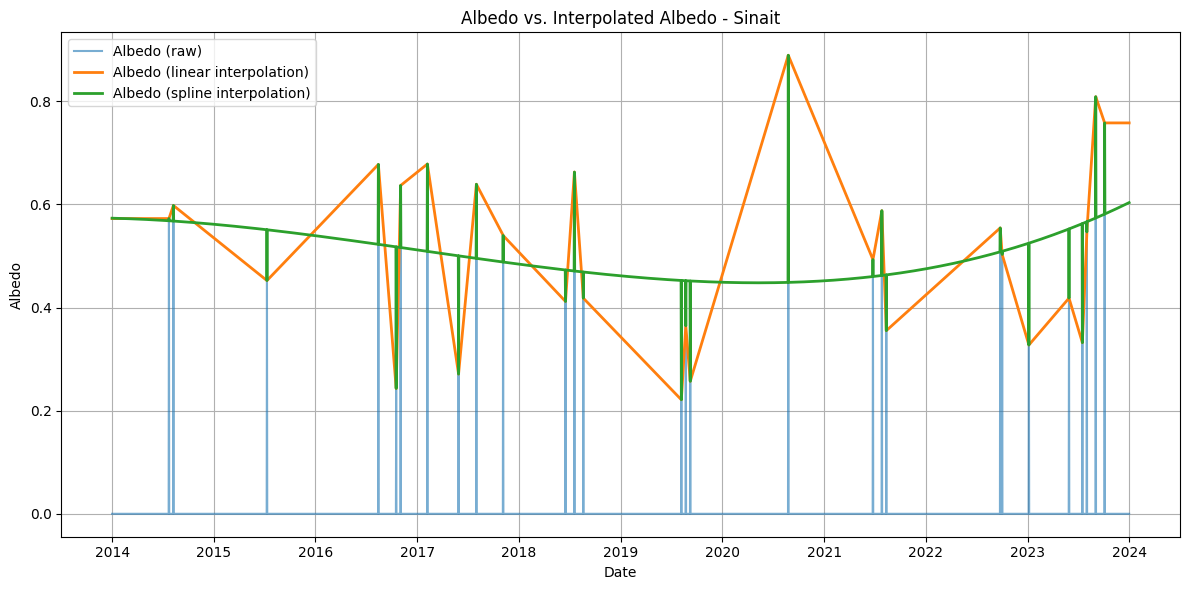

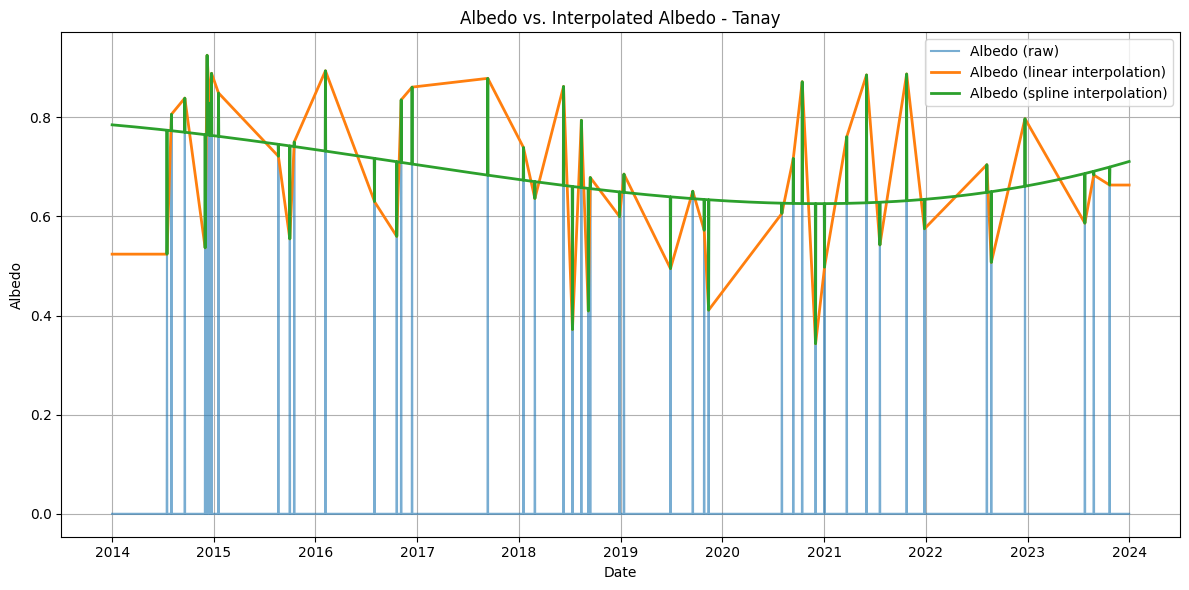

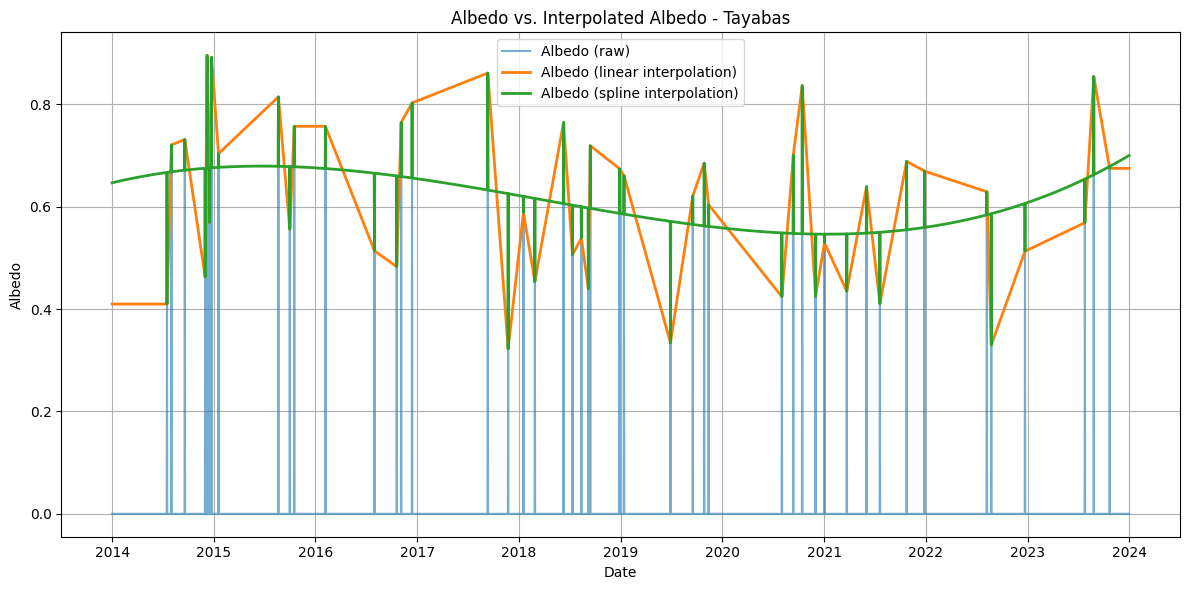

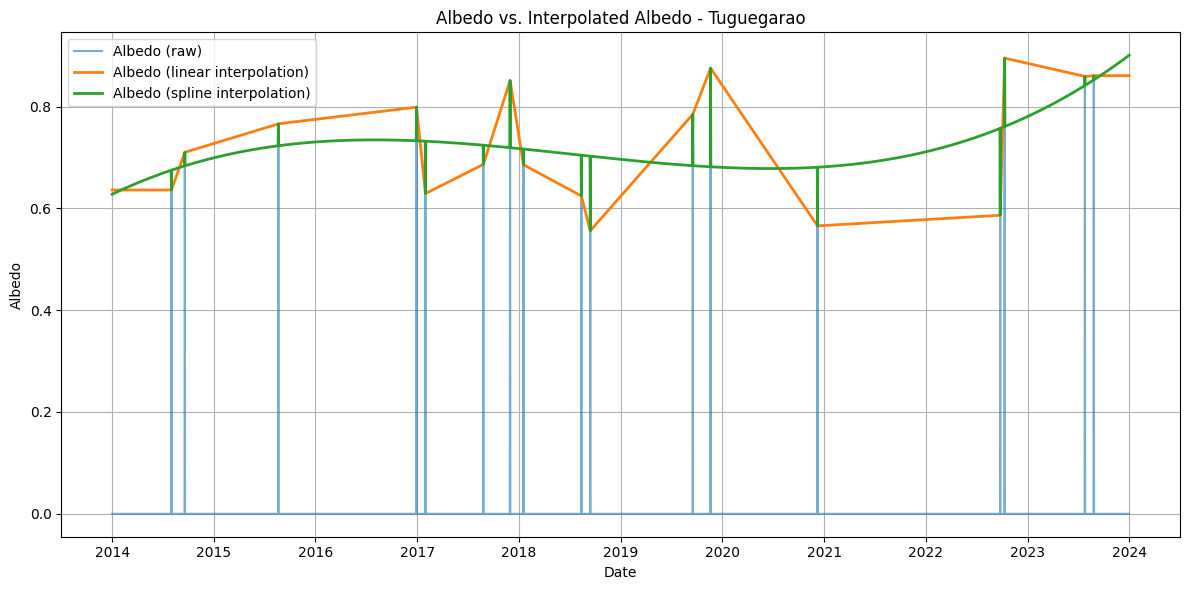

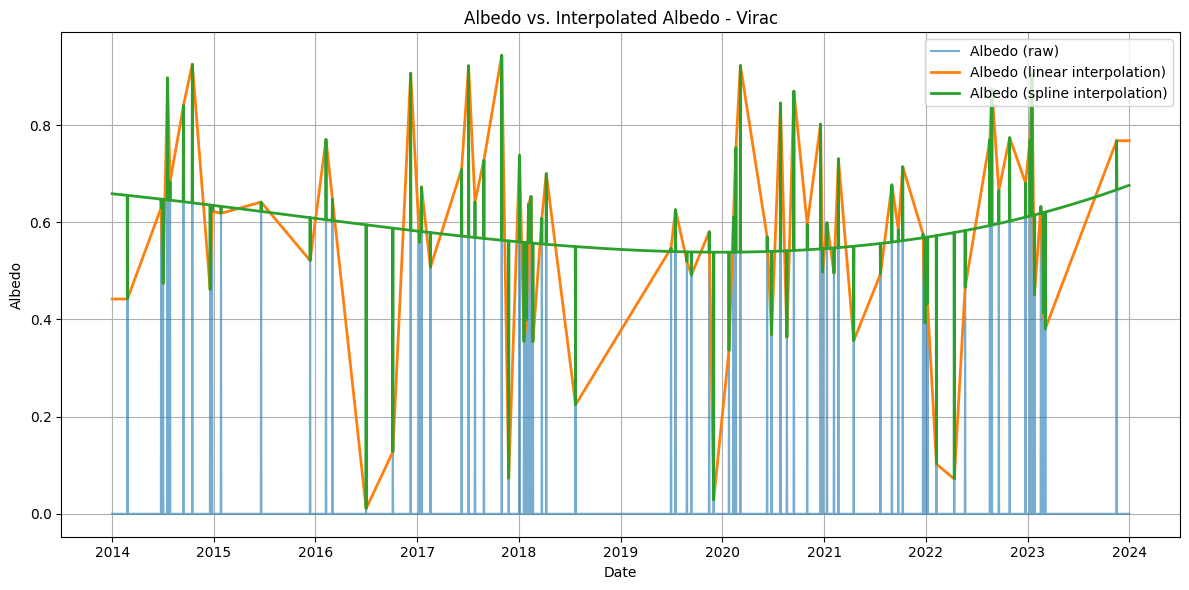

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDBI_original, NDBI_linear, NDBI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["Albedo_original"], label="Albedo (raw)", alpha=0.6)
    plt.plot(df["date"], df["Albedo_linear"], label="Albedo (linear interpolation)", linewidth=2)
    plt.plot(df["date"], df["Albedo_spline"], label="Albedo (spline interpolation)", linewidth=2)


    plt.xlabel("Date")
    plt.ylabel("Albedo")
    plt.title(f"Albedo vs. Interpolated Albedo - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Sinait", "Tanay", "Tayabas", "Tuguegarao", "Virac"]
for station in station_names:
    csv_file = f"{station}_Albedo.csv"
    plot_values(csv_file, station)